In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Catan IA
import random
import numpy as np
import networkx as nx

# State of the game

- Terrain Type :
    - 0 -> Forest 
    - 1 -> Grain
    - 2 -> Wool
    - 3 -> Ore
    - 4 -> Brick
    - 5 -> Desert

- Dev Cards :
    - 0 -> 1 VP Card
    - 1 -> Knight Card
    - 2 -> Progress Card Road Construction
    - 3 -> Progress Card Invention
    - 4 -> Progress Card Monopoly

- Map : 
    - Roads : Graph of hexagon vertices
    - Array of hexagon vertices :
        - colony
        - city
        - neighboring tiles (+ harbor)
    - Array of hexagons
    - Robber status
    
- Array of Players :
    - VP (integer)
    - Ressource Cards (list of Terrain Type indices)
    - Dev Cards Hand (list of Dev Cards indices)
    - Dev Cards (list of Dev Cards indices)
    - Largest Army (boolean)
    - Longest Road (boolean)

In [6]:
class Catan:
    """Catan artificial intelligence"""
            
    class Map:          
        n_vertices = 54;
        n_tiles = 19;
        n_edges = 72;
        
        # (vertex 1, vertex 2)
        edges = [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(8,10),(10,11),(11,12),
                 (12,13),(13,14),(14,15),(15,16),(16,17),(17,18),(17,19),(19,20),(20,21),
                 (21,22),(22,23),(23,24),(24,25),(25,26),(26,27),(27,28),(28,29),(29,30),
                 (30,31),(31,32),(32,33),(33,34),(34,35),(35,36),(36,37),(37,38),(37,39),
                 (39,40),(40,41),(41,42),(42,43),(43,44),(44,45),(45,46),(46,47),(46,48),
                 (48,49),(49,50),(50,51),(51,52),(52,53),(53,54),(1,15),(3,13),(5,11),
                 (9,26),(10,24),(12,22),(14,20),(18,38),(19,36),(21,34),(23,32),(25,30),
                 (29,47),(31,45),(33,43),(35,41),(40,54),(42,52),(44,50)];
        
        # (vertex 1, vertex 2, player)
        roads = [];
        
        # (player, settlement, city)
        vertices = [(0,0,0),(0,1,0),(0,0,1),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,0),
                    (0,0,0),(0,0,0),(0,0,0),(0,0,0),(0,0,1)];
        
        # (type, dice roll)
        tiles = [];
        
        # (tile_id, vertices)
        tile_vertex = {1 : [1,2,3,13,14,15],
                       2 : [3,4,5,11,12,13],
                       3 : [5,6,7,8,10,11],
                       4 : [14,15,16,17,19,20],
                       5 : [12,13,14,20,21,22],
                       6 : [10,11,12,22,23,24],
                       7 : [8,9,10,24,25,26],
                       8 : [17,18,19,36,37,38],
                       9 : [19,20,21,34,35,36],
                       10 : [21,22,23,32,33,34],
                       11 : [23,24,25,30,31,32],
                       12 : [25,26,27,28,29,30],
                       13 : [35,36,37,39,40,41],
                       14 : [33,34,35,41,42,43],
                       15 : [31,32,33,43,44,45],
                       16 : [29,30,31,45,46,47],
                       17 : [40,41,42,52,53,54],
                       18 : [42,43,44,50,51,52],
                       19 : [44,45,46,48,49,50]};
        
        # (vertex,resource,ratio)
        harbor_vertex = [(1,5,3),(2,5,3),(4,2,2),(5,2,2),(8,5,3),
                         (9,5,3),(16,3,2),(17,3,2),(27,5,3),(28,5,3),
                         (37,1,2),(39,1,2),(46,4,2),(47,4,2),(53,5,3),
                         (54,5,3),(50,0,2),(51,0,2)];
        robber = 10;
        
    class Player:
        VP = 0;
        resource_cards = [(0,0),(1,0),(2,0),(3,0),(4,0)];
        dev_cards_hand = [];
        dev_cards = [];
        largest_army = False;
        longest_road = False;
        n_roads = 0;
        n_colonies = 0;
    
    n_players = 0;
    players = [];
    game_map = Map();
    trade_ratio = 4;
    dev_cards = ['VP','Knight','Road Construction','Invention','Monopoly','Unknown'];
    terrain_type = ['Forest','Grain','Wool','Ore','Brick','Desert'];
    cost_road = [(0,1),(1,0),(2,0),(3,0),(4,1)]
    cost_settlement = [(0,1),(1,1),(2,1),(3,0),(4,1)]
    cost_city = [(0,0),(1,2),(2,0),(3,3),(4,0)]
    cost_dev = [(0,0),(1,1),(2,1),(3,1),(4,0)]

    def __init__(self,init):
        self.n_players = init["n_players"];
        for i in range(0, self.n_players):
            self.players.append(Catan.Player())
        
        self.players = []
        if "tiles" in init.keys():
            self.game_map.tiles = init["tiles"];
        else:
            self.generate_random_tiles();
        self.generate_vertex_path();
            
    def generate_vertex_path(self):
        G = nx.Graph();
        G.add_edges_from(self.game_map.edges);
        self.game_map.vertex_path = nx.all_pairs_shortest_path(G);
        self.game_map.G=G;
            
    def generate_random_tiles(self):
        dice = [6,3,8,2,4,5,10,5,9,6,9,10,11,3,12,8,4,11];
        tiles = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,4,4,4];
        random.shuffle(tiles);
        tiles.insert(9,5);
        self.game_map.tiles = zip(tiles,dice);
        
    def display(self):
        print("graphic display")
        
    def check_resource(self,player,cost):
        # cost is a vector of tuple of the form [(0,1),(1,0),(2,0),(3,0),(4,1)]
        # describing the minimum resources the player must have to complete the trade
        for (r,n) in self.players[player].resource_cards:
            if n < cost[r][1]:
                print("poor bastard you can't do that")
                return(False)
        return(True)
        
    def add_road(self,edge,player):
        # edge : (vertex 1, vertex 2)
        # check that it is legal to add a road
        if not edge in self.game_map.edges:
            print("edge is not valid")
            return
        
        valid_edges = [];
        for (v1,v2,p) in self.game_map.road:
            if p == player:
                valid_edges.append((v1,v2));
        
        valid_edges = set(sum(valid_edges, ()));
        
        if  valid_edges.intersection(set(edge)) == set():
            print("edge is not valid")
            return
        
        # check that that the player have the resources to build a road
        if check_resource(player,self.coast_road):
            self.game_map.roads.append((edge[0],edge[1],player))
            
    def generate_all_construction_sites(self):
        v,s,c = zip(*self.game_map.vertices);
        built_vertices = [];
        for (si,ci) in zip(s,c):
            built_vertices.append(si or ci);
        built_vertices = [i for i, x in enumerate(built_vertices) if x == 1];
#        for v in range(1,55):
#            if not self.game_map.vertex_path[v] in built_vertices:
                
            
        
    def add_city(self,vertex,player):
        # check that it is legal to add a city
        if not vertex in self.game_map.edges:
            print("edge is not valid")
            return
        
        valid_edges = [];
        for (v1,v2,p) in self.game_map.road:
            if p == player:
                valid_edges.append((v1,v2));
        
        valid_edges = set(sum(valid_edges, ()));
        
        if  valid_edges.intersection(set(edge)) == set():
            print("edge is not valid")
            return
        
        # check that that the player have the resources to build a road
        if check_resource(player,self.coast_road):
            self.game_map.roads.append((edge[0],edge[1],player))
            
#    def add_colony(self,vertex,player):
    

In [7]:
init = {
    "n_players" : 3,
    "tiles" : [(0,6),(2,3),(2,8),(1,2),(3,4),(1,5),
               (0,10),(0,5),(4,9),(5,0),(3,6),(1,9),
               (1,10),(3,11),(0,3),(2,12),(4,8),(2,4),(4,11)],
}

In [8]:
IA = Catan(init)

/usr/local/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.4/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.4/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


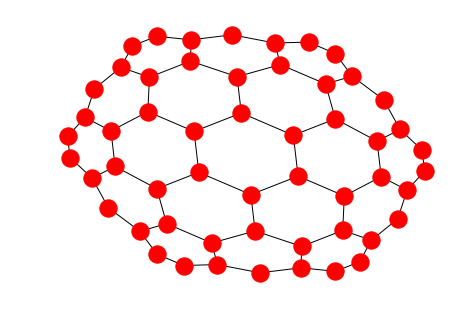

In [9]:
#pos = nx.spring_layout(IA.game_map.G,dim=2,k=0.04,iterations=1000)
pos = nx.spectral_layout(IA.game_map.G,scale=1)
nx.draw(IA.game_map.G,pos)


In [11]:
def hex_vertices(center,edge_length):
    v = [];
    for i in range(0,6):
        angle = np.pi/180 * (60 * i +30);
        v.append((center[0] + edge_length * np.cos(angle), center[1] + edge_length * np.sin(angle)))   
    return v

In [12]:
# y = (0.8464,0.6732,0.5,0.3268,0.1536)
# xi = (0.1,0.3,0.5,0.7,0.9)
# xp = (0.2,0.4,0.6,0.8)

centers = [(0.3, 0.8464),
          (0.5, 0.8464),
          (0.7, 0.8464),
          (0.2, 0.6732),
          (0.4, 0.6732),
          (0.6, 0.6732),
          (0.8, 0.6732),
          (0.1, 0.5),
          (0.3, 0.5),
          (0.5, 0.5),
          (0.7, 0.5),
          (0.9, 0.5),
          (0.2, 0.3268),
          (0.4, 0.3268),
          (0.6, 0.3268),
          (0.8, 0.3268),
          (0.3, 0.1536),
          (0.5, 0.1536),
          (0.7, 0.1536)]

pos = []
for c in centers:
    pos.append(hex_vertices(c,0.1))

[[(0.38660254037844388, 0.89640000000000009),
  (0.29999999999999999, 0.94640000000000002),
  (0.2133974596215561, 0.89640000000000009),
  (0.21339745962155612, 0.7964),
  (0.29999999999999999, 0.74640000000000006),
  (0.38660254037844383, 0.7964)],
 [(0.58660254037844384, 0.89640000000000009),
  (0.5, 0.94640000000000002),
  (0.41339745962155611, 0.89640000000000009),
  (0.41339745962155616, 0.7964),
  (0.5, 0.74640000000000006),
  (0.58660254037844384, 0.7964)],
 [(0.78660254037844379, 0.89640000000000009),
  (0.69999999999999996, 0.94640000000000002),
  (0.61339745962155612, 0.89640000000000009),
  (0.61339745962155612, 0.7964),
  (0.69999999999999996, 0.74640000000000006),
  (0.78660254037844379, 0.7964)],
 [(0.2866025403784439, 0.72320000000000007),
  (0.20000000000000001, 0.7732),
  (0.11339745962155613, 0.72320000000000007),
  (0.11339745962155615, 0.62319999999999998),
  (0.19999999999999998, 0.57320000000000004),
  (0.28660254037844385, 0.62319999999999998)],
 [(0.486602540378

In [23]:
pos = sum(pos,[])

TypeError: can only concatenate list (not "tuple") to list

In [35]:
a=[]
b=3
for i in range(0, b):
    a.append(Catan.Player())
a[0].resource_cards[1]

(1, 0)

In [101]:
for v in range(1,55):
    print(Catan.game_map.vertices[v]);
    


(0, 1, 0)
(0, 0, 1)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 1)
